In [28]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="red")

import pandas as pd
from fiesta.plot import corner_plot, LightcurvePlotter
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.inference.injection import InjectionPyblastafterglow
from fiesta.inference.likelihood import EMLikelihood
from fiesta.utils import load_event_data


## Variable systematic uncertainty

Load the data

In [15]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)
data = load_event_data("./data/injection_pyblastafterglow_gaussian.dat")
trigger_time = 58849

var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "Gamma0", "sys_err"]
posterior_fiesta = np.load("./outdir_fiesta/results_production.npz")["chains"].reshape(-1, 10)
posterior_fiesta = {key: col for key, col in zip(var_names, posterior_fiesta.T)}
posterior_fiesta["log_prob"] = np.load("./outdir_fiesta/results_production.npz")["log_prob"].reshape(-1,)

Make corner plot

In [34]:

model = AfterglowFlux("pbag_gaussian_CVAE",
                      filters = data.keys())

likelihood = EMLikelihood(model=model,
                          data=data,
                          trigger_time=trigger_time,
                          tmin=0.01,
                          tmax=200.,
                          fixed_params={"redshift": 0., "luminosity_distance": 40.})

lc_plotter = LightcurvePlotter(posterior_fiesta,
                  likelihood,
                  free_syserr=True)

injection = InjectionPyblastafterglow(jet_type=0, 
                                      filters=model.filters, 
                                      N_datapoints=75, 
                                      error_budget=0.1, 
                                      tmin=1e-2, 
                                      tmax=200, 
                                      trigger_time=trigger_time)

true_lc = injection._get_injection_lc_from_file(params, file="/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_gaussian_raw_data.h5")

10:54 fiesta INFO    : Loading surrogate pbag_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
INFO:fiesta:Loading surrogate pbag_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
10:54 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
INFO:fiesta:	 inclination_EM: (0, 1.5707963267948966)
10:54 fiesta INFO    : 	 log10_E0: (47, 57)
INFO:fiesta:	 log10_E0: (47, 57)
10:54 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
INFO:fiesta:	 thetaCore: (0.01, 0.6283185307179586)
10:54 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
INFO:fiesta:	 alphaWing: (0.2, 3.5)
10:54 fiesta INFO    : 	 log10_n0: (-6, 2)
INFO:fiesta:	 log10_n0: (-6, 2)
10:54 fiesta INFO    : 	 p: (2.01, 3)
INFO:fiesta:	 p: (2.01, 3)
10:54 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
INFO:fiesta:	 log10_epsilon_e: (-4, 0)
10:54 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
INFO:fiesta:	 log10_epsilon_B: (-8, 0)
10:54 fiesta INFO    : 	 Gamma0: (100

Found suitable injection with {'inclination_EM': 0.2060914929158214, 'log10_E0': 50.59344127606526, 'thetaCore': 0.04976415765030157, 'alphaWing': 2.042897136157272, 'p': 2.5486976362139857, 'log10_n0': 0.7147196833365239, 'log10_epsilon_e': -2.1880998297135523, 'log10_epsilon_B': -2.5237415342908207, 'Gamma0': 899.9547576502542, 'luminosity_distance': 40.0, 'redshift': 0.0, 'trigger_time': 58849}


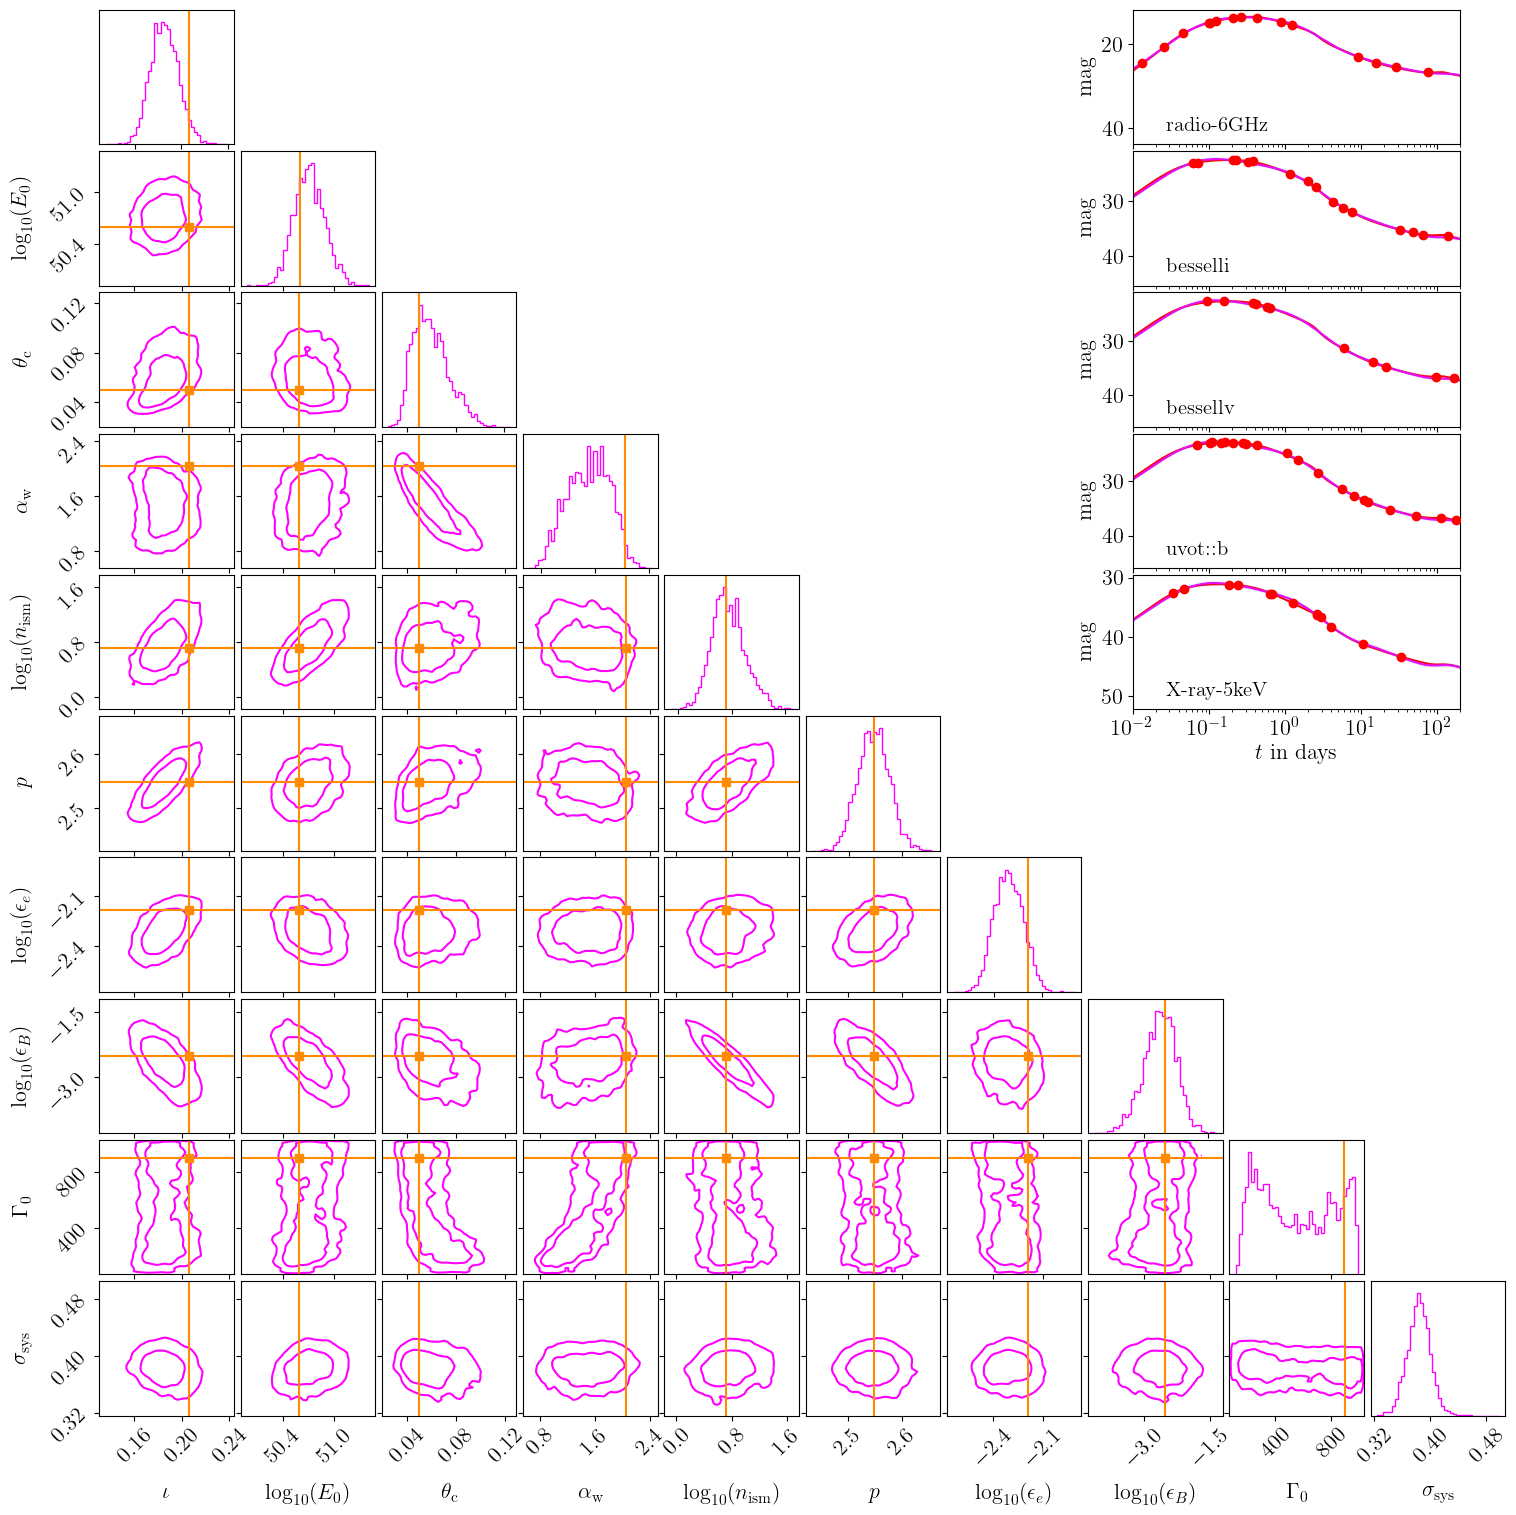

In [36]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=var_names, truths=params, color="magenta")


def plot_lcs(j, filt):

    for k in range(7, 10):
        fig.delaxes(ax[j, k])

    pos1 = ax[j, 7].get_position()
    pos2 = ax[j, 9].get_position()

    x0 = pos1.x0+0.03
    y0 = pos1.y0
    width = pos2.x1 - x0
    height = pos1.height  # same height as original row

    ax_merged = fig.add_axes([x0, y0, width-0.03, height])

    ax_merged.plot(true_lc[0], true_lc[1][filt], color="red")
    lc_plotter.plot_data(ax_merged, filt, color="red")
    lc_plotter.plot_best_fit_lc(ax_merged, filt, color="magenta")
    lc_plotter.plot_sys_uncertainty_band(ax_merged, filt)

    ax_merged.set_xscale("log")
    ax_merged.set_xlim(1e-2, 200)

    ax_merged.invert_yaxis()
    ax_merged.set_ylabel("mag")
    ax_merged.text(0.1, 0.1, filt, transform=ax_merged.transAxes, fontsize=15)
    
    if j!=4:
        ax_merged.set_xticklabels([])

    if j==4:
        ax_merged.set_xlabel("$t$ in days")



plot_lcs(0, "radio-6GHz")
plot_lcs(1, "besselli")
plot_lcs(2, "bessellv")
plot_lcs(3, "uvot::b")
plot_lcs(4, "X-ray-5keV")


fig.savefig("./figures/injection_pbag_gaussian.pdf", dpi=250, bbox_inches="tight")


/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/tmp/ipykernel_5926/1886067861.py:9: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15, left=0.15)


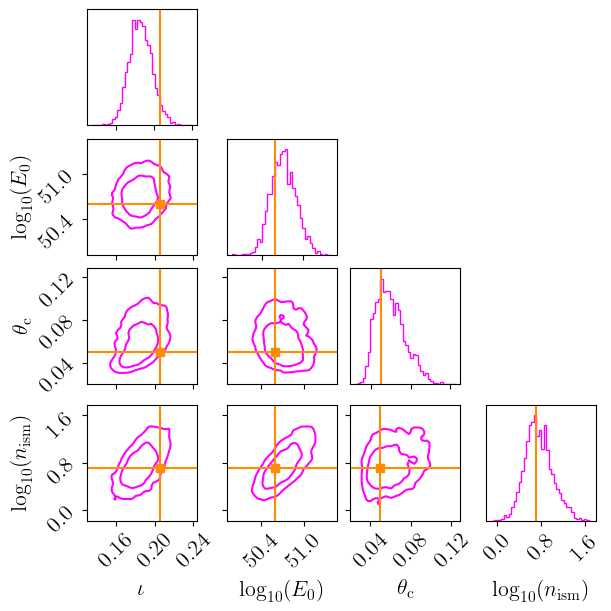

In [7]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=["inclination_EM", "log10_E0", "thetaCore", "log10_n0"], truths=params, color="magenta")

handles = []
for c in ["magenta"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)


fig.subplots_adjust(bottom=0.15, left=0.15)
fig.savefig("./figures/injection_pbag_gaussian.pdf", dpi=250, bbox_inches="tight")

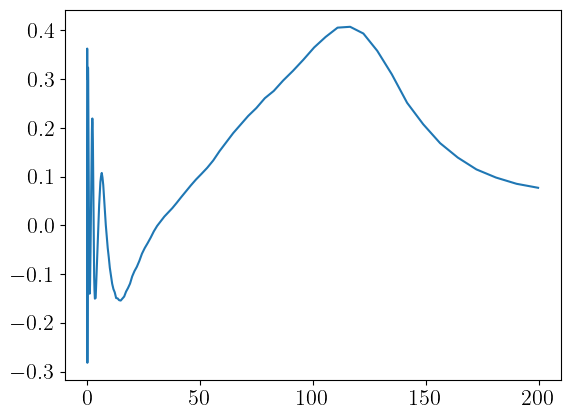

In [38]:
plt.plot(lc_plotter.t_best_fit, lc_plotter.best_fit_lc["bessellv"] - np.interp(lc_plotter.t_best_fit, true_lc[0], true_lc[1]["bessellv"]))